# Second step in pipeline

In [3]:
import os
import numpy as np
import pandas as pd
import scienceplots
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from matplotlib.pyplot import figure
%matplotlib inline

## Implement modified TopicTiling Algorithm (Riedl, Biemann, 2012) adjusted for HDBSCAN topic probaiblity vectors

In [2]:
# Functions for segmentation. Segmentation main call function calls all of the above. 

def smoothing(topic_proba_df, threshold):
    """Take the df and output new df with smoothed_topic_probs column 
        threshold (float): all probabilities under the thresold will be set to 0.    
    """
    smoothed_topic_proabilities_ls = []

    for i in range(len(topic_proba_df)):
        smoothed_topic_proabilities = np.array(topic_proba_df.topic_probs[i])
        smoothed_topic_proabilities[smoothed_topic_proabilities < threshold] = 0
        smoothed_topic_proabilities_ls.append(smoothed_topic_proabilities)
    topic_proba_df['smoothed_topic_probabilities'] = smoothed_topic_proabilities_ls

    return topic_proba_df


def window_cosine_sim(dataframe, window_size=3):
    """
    Compute the cosine similarities between consecutive window blocks in a given dataframe.

    Args:
        dataframe (pandas.DataFrame): A dataframe containing topic probabilities.
        window_size (int, optional): The size of the window to use for cosine similarity computation. Defaults to 3.

    Returns:
        numpy.ndarray: An array of cosine similarities between consecutive window blocks.
    """
    transcript_cosine_similarities = []

    for p in range(window_size, len(dataframe)-window_size):
        w_l = dataframe.smoothed_topic_probabilities[p-window_size:p]
        w_r = dataframe.smoothed_topic_probabilities[p:p+window_size]

        # Add probability vectors in blocks
        w_l_added = np.add.reduce(w_l)
        w_r_added = np.add.reduce(w_r)

        # Compute cosine similarity between summed vecors of the windows
        transcript_cosine_similarities.append(np.dot(w_l_added, w_r_added)/(np.linalg.norm(w_l_added) * np.linalg.norm(w_r_added)))
        
    return np.array(transcript_cosine_similarities)


def find_minimas(window_cosines, window_size, print_state, height_param):
    """
    Find the minimas in the cosine similarity values.

    Args:
        window_cosines (numpy.ndarray): An array of cosine similarities between consecutive window blocks.
        window_size (int): The size of the window used for cosine similarity computation.
        print_state (bool): print information about candidate boundaries.
        height_param (float, optional): The minimum height for a peak to be considered a minima. Defaults to -0.995.

    Returns:
        numpy.ndarray: An array containing the indices of the identified minimas.
    """
    window_cosines_neg = window_cosines*-1
    # Find index of minimas, distance = 3 since the smallest segment in our annotations is 3 sentences
    minimas, _ = find_peaks(window_cosines_neg, distance=3, width=2, height=height_param*-1)
    if print_state == 1:
        for position in minimas:
            print(f"Candidate boundary at sent. {position+window_size}, p:{position}, value (cos sim): {window_cosines[position]:.4f}")
    
    return minimas


def hl(p, cos_sims):
    """
    Compute the maximum value of the cosine similarities to the left of the given position.

    Args:
        p (int): The position in the cosine similarities array.
        cos_sims (numpy.ndarray): An array of cosine similarities.

    Returns:
        float: The maximum value of the cosine similarities to the left of the given position.
    """
    max_val = cos_sims[p]
    side_check_range = 3
    for i in range(p-1, 0, -1):
        try: # handle control flow for the first 10 values in cos_sims
            max_found_in_slice = cos_sims[i-side_check_range: i].max()
            if max_found_in_slice >= max_val:
                max_val = max_found_in_slice
                continue
            else:
                break
        except:
            break
    return max_val


def hr(p, cos_sims):
    """
    Compute the maximum value of the cosine similarities to the right of the given position.

    Args:
        p (int): The position in the cosine similarities array.
        cos_sims (numpy.ndarray): An array of cosine similarities.

    Returns:
        float: The maximum value of the cosine similarities to the right of the given position
    """
    max_val = cos_sims[p]
    side_check_range = 3
    for i in range(p+1, len(cos_sims)):
        try: # handle control flow for the last 10 values in cos_sims
            max_found_in_slice = cos_sims[i: i+side_check_range].max()
            if max_found_in_slice >= max_val:
                max_val = max_found_in_slice
                continue
            else:
                break
        except:
              break
    
    return max_val


def depth_scores(cos_sims, minimas):
    """
    Calculate the depth scores for each minima in the cosine similarities.
    Args:
    cos_sims (numpy.ndarray): An array of cosine similarities.
    minimas (numpy.ndarray): An array containing the indices of the identified minimas.

    Returns:
    list: A list of depth scores for each minima.
    """
    scores = []
    for p in minimas:
        dp = 0.5 * (hl(p, cos_sims) + hr(p, cos_sims) - cos_sims[p]*2)
        scores.append(dp)
    return scores


def segment_boundaries(depth_scores, minimas_list, window_size, print_state):
    """
    Determine the segment boundaries based on depth scores and a threshold value.
    Args:
    depth_scores (list): A list of depth scores for each minima.
    minimas_list (numpy.ndarray): An array containing the indices of the identified minimas.
    window_size (int): The size of the window used for cosine similarity computation.
    print_state (bool): print information about segment boundaries.


    Returns:
    list: A list of segment boundaries.
    """
    threshold = np.mean(depth_scores) - (np.std(depth_scores)/2)
    boundaries = []
    for index, score in enumerate(depth_scores):
        if score >= threshold:
            boundaries.append(minimas_list[index] + window_size)
            if print_state == 1:
                print(f"Boundary at sentence {minimas_list[index] + window_size}, p:{minimas_list[index]}, depth score: {score:.4f}")
    return boundaries


def plot_cosine_scores(cosine_similarities_for_windows, window_size, boundaries=None):
    """
    Plot the cosine similarities and negative cosine similarities over transcript windows.

    Args:
    cosine_similarities_for_windows (numpy.ndarray): An array of cosine similarities between consecutive window blocks.
    window_size (int): window sice of segmenter algorithm. Used in title.
    boundaries (list, optional): List of int:s containing placements of segment boundaries. 
    """
    plt.style.use(['science','no-latex'])
    figure(figsize=(6, 4.5))
    
    ax = sns.lineplot(cosine_similarities_for_windows)
    ax.set_ylim(bottom=0, top=1)
    ax.set_xlim(left=0, right=len(cosine_similarities_for_windows))
    ax.set_xlabel("p\npredicted segment breaks marked in red")
    ax.set_ylabel("Cosine similarity")
    if boundaries != None:
        boundaries_np = np.array(boundaries) - window_size
        ax = sns.scatterplot(x= boundaries_np, y=cosine_similarities_for_windows[boundaries_np], marker="x", color='r')

    ax.set_title(f"Cos. Sim. Over Transcript Windows [win. size: {window_size}]")
    plt.show()


def segmentation_main_call(dataframe, print_state_min, print_state_depth, height=0.995, window=3, smooting_threshold=1e-20):
    """
    Perform text segmentation by finding segment boundaries based on cosine similarity values.

    Args:
    dataframe (pandas.DataFrame): A dataframe containing topic probabilities.
    print_state_min (bool): print information about candidate boundaries.
    print_state_depth (bool): print information about segment boundaries.
    window_size (int, optional): The size of the window to use for cosine similarity computation. Defaults to 3.

    Returns:
    list: A list of segment boundaries.
    """
    smoothed_probability_df = smoothing(dataframe, smooting_threshold)
    window_cosines = window_cosine_sim(smoothed_probability_df, window_size=window)
    min = find_minimas(window_cosines, print_state=print_state_min, window_size=window, height_param=height)
    ds = depth_scores(window_cosines, min)
    bounds = segment_boundaries(ds, min, window_size=window, print_state=print_state_depth)
    return bounds


def close_match(actual_breaks, predicted_breaks, close_definition=3): 
    """
    Find close matches between actual and predicted breaks. Returns accuracy, actual number of close matches and the positions of the close matches.
    actual_breaks: set of actual breaks
    predicted_breaks: set of predicted breaks
    close_definition: int, how many sentences a segment break can be away from the actual break to count as close. 
    """
    s = predicted_breaks.copy()
    new_set = set()
    for element in s:
        for i in range(1, close_definition+1): 
            new_set.add(element-i)
            new_set.add(element+i)
    s.update(new_set)

    intersection_actual_pred = actual_breaks.intersection(s)
    return (len(intersection_actual_pred)/len(actual_breaks)), len(intersection_actual_pred), intersection_actual_pred

## Pipeline step 2

In [77]:
# Try out different hyperparameter settings and get KPIs for all 20 annotated transcripts
actual = pd.read_pickle('annotations.pkl')

# walk directory to loop through files
for dirpath, _, files in os.walk('../Thesis/annotated_probabilities_msize200'):
    
    # initialise lists for appending scores
    episode = []; actual_breaks = []; predicted_breaks = []; exact_matches = []
    close_matches = []; accuracy = []; window_param = []; height_param = []; len_of_transcript = []; window_diff_ls = []

    # For each file, get KPIs for different hyperparameter settings and add to lists
    for file in files:
        eps_id = file[:-4].split('_')[4]
        path = os.path.join(dirpath, file)
        topic_proba_dens_vector = np.load(path)
        vector_length = len(topic_proba_dens_vector)
        annotated_probabilities_df = pd.DataFrame({"sentence_no":[i for i in range(vector_length)],
                                                    "topic_probs": topic_proba_dens_vector.tolist()})

        # get predicted bounds
        # he = [0.99, 0.95, 0.9]
        # for h in he:
        h=0.95
        for win in range(2, 41, 2):
            if win*2 >= len(annotated_probabilities_df.index):
                print(win)
                break
            else:
                predicted_bounds = segmentation_main_call(annotated_probabilities_df,\
                                                            print_state_min=False,\
                                                            print_state_depth=False,\
                                                            window=win, height=0.95)
                predicted_bounds_set = set(predicted_bounds)

                # get actual bounds
                actual_bounds = actual[actual.episode_id == eps_id].iloc[0,2]

                # get exact and close matches
                actual_bounds_set = set(actual_bounds)
                
                acc, num_matches, list = close_match(actual_bounds_set, predicted_bounds_set, close_definition=5)
                
                # Append to build dataframe downstream
                episode.append(eps_id)
                actual_breaks.append(len(actual_bounds_set))
                predicted_breaks.append(len(predicted_bounds))
                exact_matches.append(len(predicted_bounds_set.intersection(actual_bounds_set)))
                close_matches.append(num_matches)
                accuracy.append(acc)
                window_param.append(win)
                height_param.append(h)
                len_of_transcript.append(vector_length)

                # window diff, k = window size
                k = 4
                window_diff_unnormalised = 0
                for i in range(vector_length - k):
                    sliding_window = set([w for w in range(i, i + k, 1)])
                    actual_in_sliding_window = len(actual_bounds_set.intersection(sliding_window)) # ref
                    predicted_in_sliding_window = len(predicted_bounds_set.intersection(sliding_window)) # hyp
                    window_diff_absolute = (np.abs(actual_in_sliding_window - predicted_in_sliding_window)) / k
                    window_diff_unnormalised += window_diff_absolute
                window_diff = (1/(vector_length-k)) * window_diff_unnormalised
                window_diff_ls.append(window_diff)
        print(eps_id, 'done')

        
    # Create dataframe with all figures for comparison
    evaluation_df = pd.DataFrame({'episode': episode,
                                  'actual_breaks': actual_breaks,
                                  'predicted_breaks': predicted_breaks,
                                  'exact_matches': exact_matches,
                                  'close_matches': close_matches,
                                  'window_diff': window_diff_ls,
                                  'accuracy_close_match': accuracy,
                                  'window_size': window_param,
                                  'height': height_param,
                                  'len_of_transcript': len_of_transcript})

print(evaluation_df.shape)

13NDTKL5ZGs8cb8dojW3bz done
6preEOWrgR9eRr938upFgv done
28
2Bp5vd9GAmEpZzjEtGQBFD done


/Users/oskarmunckafrosenschold/Documents/Thesis/thesisenv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/oskarmunckafrosenschold/Documents/Thesis/thesisenv/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/oskarmunckafrosenschold/Documents/Thesis/thesisenv/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/oskarmunckafrosenschold/Documents/Thesis/thesisenv/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/oskarmunckafrosenschold/Documents/Thesis/thesisenv/lib/python3.10/site-packages/numpy/core/_methods.py:257: Ru

0ZGQ63222rqX5TD5ZrMmcN done
19W5dgUcFseQZBmcVF4coc done
3iydyD9rAb1f6rmvmgpwS4 done
0bXWB28GwN8OiqC1ykRrRX done
28IWswylk2FvkebOehoCkL done
3DR5Qa40Mc17AiBYfmC29U done
3RT2j2BG8ILNYKjxsNhfvZ done
3p9FLEH5V5sCGHhGubaYZc done
5Sg6efUjypR4m6p9eYBXpm done
4y67J0Fmgm5L7TPPsUunwo done
1VBbCB6ja5pPdU2wrBy27N done


/Users/oskarmunckafrosenschold/Documents/Thesis/thesisenv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/oskarmunckafrosenschold/Documents/Thesis/thesisenv/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/oskarmunckafrosenschold/Documents/Thesis/thesisenv/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/oskarmunckafrosenschold/Documents/Thesis/thesisenv/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/oskarmunckafrosenschold/Documents/Thesis/thesisenv/lib/python3.10/site-packages/numpy/core/_methods.py:257: Ru

7A7swZJL0AtFghauiGLadV done
4pFaG2QLnDr95gqDQFEWoh done


/Users/oskarmunckafrosenschold/Documents/Thesis/thesisenv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/oskarmunckafrosenschold/Documents/Thesis/thesisenv/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/oskarmunckafrosenschold/Documents/Thesis/thesisenv/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/oskarmunckafrosenschold/Documents/Thesis/thesisenv/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/oskarmunckafrosenschold/Documents/Thesis/thesisenv/lib/python3.10/site-packages/numpy/core/_methods.py:257: Ru

38
53DrbE5nPJskpPT0PtOi9O done
5ts4p0QlyePWCgIB2W1wLf done
7mv5E2yb2yVQU34OiQ1vqv done
4DUIcbw3EZpeYUC2mcxV0D done
(391, 10)


In [78]:
evaluation_df.to_csv('../Thesis/evaluation/eval_200.csv')

In [7]:
# TP: close_matches
# FP: predicted breaks - close matches
# FN: actual breaks - close matches
# TN: transcript_len - predicted breaks - actual breaks + close matches

# evaluation_df['true_positives'] = evaluation_df.close_matches
# evaluation_df['false_positives'] = evaluation_df.predicted_breaks - evaluation_df.close_matches
# evaluation_df['false_negatives'] = evaluation_df.actual_breaks - evaluation_df.close_matches
# evaluation_df['true_negatives'] = evaluation_df.len_of_transcript - evaluation_df.predicted_breaks - evaluation_df.actual_breaks + evaluation_df.close_matches
# evaluation_df['precision'] = evaluation_df.true_positives/(evaluation_df.true_positives + evaluation_df.false_positives)
# evaluation_df['recall'] = evaluation_df.true_positives/(evaluation_df.true_positives + evaluation_df.false_negatives)
# evaluation_df['F1'] = evaluation_df.true_positives / (evaluation_df.true_positives + 0.5*(evaluation_df.false_positives + evaluation_df.false_negatives))
evaluation_df.loc[0:50]
# evaluation_df.episode.unique()

# after

,episode,actual_breaks,predicted_breaks,exact_matches,close_matches,window_diff,accuracy_close_match,window_size,height,len_of_transcript
0,13NDTKL5ZGs8cb8dojW3bz,10,19,1,7,0.095455,0.700000,2,0.95,224
1,13NDTKL5ZGs8cb8dojW3bz,10,14,0,7,0.086364,0.700000,4,0.95,224
2,13NDTKL5ZGs8cb8dojW3bz,10,16,0,6,0.106818,0.600000,6,0.95,224
3,13NDTKL5ZGs8cb8dojW3bz,10,11,0,6,0.075000,0.600000,8,0.95,224
4,13NDTKL5ZGs8cb8dojW3bz,10,12,0,6,0.070455,0.600000,10,0.95,224
5,13NDTKL5ZGs8cb8dojW3bz,10,10,1,4,0.068182,0.400000,12,0.95,224
6,13NDTKL5ZGs8cb8dojW3bz,10,10,0,5,0.075000,0.500000,14,0.95,224
7,13NDTKL5ZGs8cb8dojW3bz,10,12,0,6,0.081818,0.600000,16,0.95,224
8,13NDTKL5ZGs8cb8dojW3bz,10,10,0,5,0.084091,0.500000,18,0.95,224
9,13NDTKL5ZGs8cb8dojW3bz,10,9,0,5,0.081818,0.500000,20,0.95,224


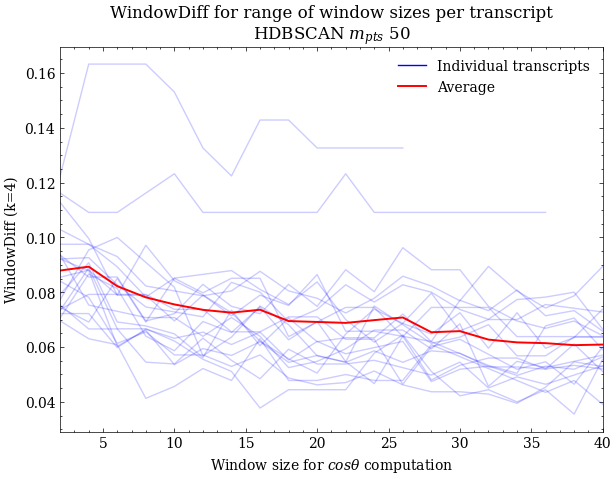

In [73]:
# Plot evaluation metric over different k for each annotated transcript
grouped_df = evaluation_df.groupby('window_size')[['window_diff']].mean()  # get average

figure(figsize=(7, 5))
palette = sns.color_palette(['blue'], 20)
ax1 = sns.lineplot(evaluation_df, x='window_size', y='window_diff', hue='episode', palette=palette, alpha=0.2)
ax2 = sns.lineplot(data = grouped_df, x='window_size', y='window_diff', color='red', alpha=1, label='Average', linewidth=1.4)
current_handles, current_labels = plt.gca().get_legend_handles_labels()  # get legend obejcts 
plt.legend(current_handles[-2:], ['Individual transcripts','Average'])  # modify legend
plt.xlim(min(evaluation_df.window_size), max(evaluation_df.window_size))
plt.ylim(0.03, 0.19)
plt.ylabel('WindowDiff (k=4)')
plt.xlabel(r'Window size for $cos \theta$ computation')
plt.title('WindowDiff for range of window sizes per transcript\nHDBSCAN $m_{pts}$ 50')
plt.show()

In [79]:
eval50 = pd.read_csv('../Thesis/evaluation/eval_50.csv')
eval200 = pd.read_csv('../Thesis/evaluation/eval_200.csv')

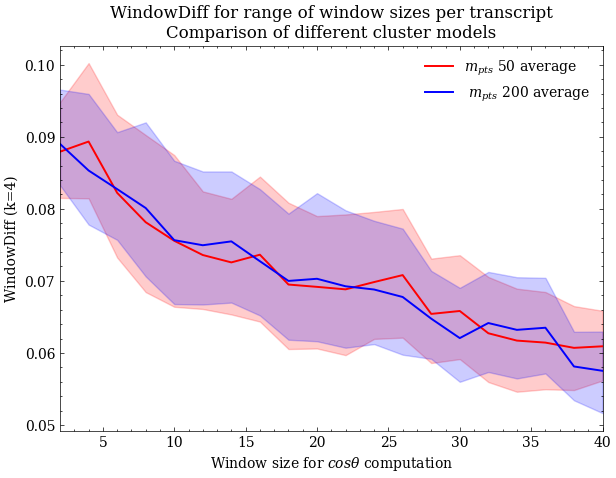

In [85]:
figure(figsize=(7, 5))

ax1 = sns.lineplot(data = eval50, x='window_size', y='window_diff', color='red', alpha=1, label='$m_{pts}$ 50 average', linewidth=1.4)
ax2 = sns.lineplot(data = eval200, x='window_size', y='window_diff', color='blue', alpha=1, label=' $m_{pts}$ 200 average', linewidth=1.4)

plt.xlim(min(evaluation_df.window_size), max(evaluation_df.window_size))
plt.ylabel('WindowDiff (k=4)')
plt.xlabel(r'Window size for $cos \theta$ computation')
plt.title('WindowDiff for range of window sizes per transcript\nComparison of different cluster models')
plt.show()

### Investigate individual transcripts

In [5]:
# load sentence probabilities from 1 step
sent_proba = np.load('../Thesis/probabilities.npy')
print(sent_proba.shape)

# make dataframe for processing
pipeline_df = pd.DataFrame({"sentence_no":[i for i in range(len(sent_proba))], "topic_probs": sent_proba.tolist()})
pipeline_df.head()

(599, 156)


,sentence_no,topic_probs
0,0,"[2.4833561188639078e-39, 2.5374959198157553e-3..."
1,1,"[9.579392743571795e-93, 9.994391142939728e-93,..."
2,2,"[1.1744153416560099e-56, 1.1848503397401329e-5..."
3,3,"[9.690914595314094e-93, 1.0109413697071008e-92..."
4,4,"[1.0595774955327207e-47, 1.0755329427821354e-4..."


0.9139078213572053
0.012804334275043489
0.47196376992925965


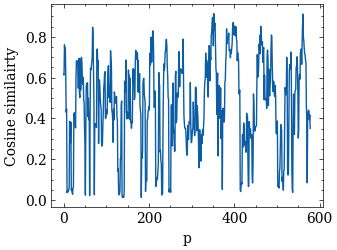

In [27]:
figure = figsize=(6, 4.6)
smothed_probs = smoothing(pipeline_df, threshold=0.0000001)
cos_sims = window_cosine_sim(smothed_probs, 10)
print(cos_sims.max())
print(cos_sims.min())
print(cos_sims.mean())
sns.lineplot(cos_sims)
plt.ylabel('Cosine similairty')
plt.xlabel('p')
plt.show()
# Sentence, HDBSCAN 200, window 2, height 0.95

Window size: 34, segments: 26


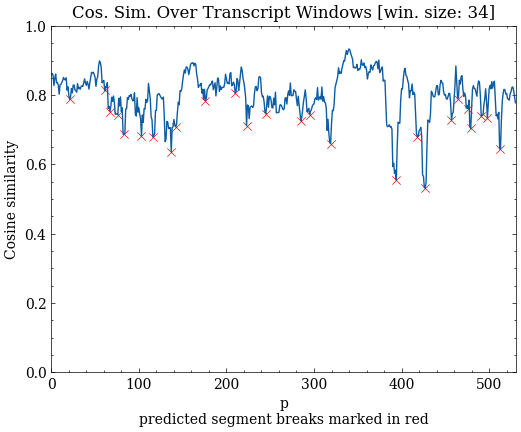

In [56]:
# Plot and analyse with different size windows
windows = [i for i in range(34, 35, 2)]

for win in windows:
    bounds = segmentation_main_call(pipeline_df, print_state_min=False, print_state_depth=False, window=win, height=0.95)
    cos_sims = window_cosine_sim(pipeline_df, window_size=win)
    print(f'Window size: {win}, segments: {len(bounds)}')
    plot_cosine_scores(cos_sims, window_size=win, boundaries=bounds)

# after width arg

## Testing with synthetic data

### Generate synthetic data

In [3]:
# Generate synthetic topic probabilities
def generate_topic_probs(num_topics, num_sentences, topic_shift_interval):
    topic_probs = []

    np.random.seed(42)
    for i in range(num_sentences):
        if i % topic_shift_interval == 0:
            current_topic = np.random.dirichlet(np.ones(num_topics))
        
        noise = np.random.uniform(0.01, 0.05, num_topics)
        noisy_current_topic = current_topic + noise
        noisy_current_topic /= np.sum(noisy_current_topic)
        
        topic_probs.append(noisy_current_topic)

    return topic_probs

# Parameters for the synthetic dataset
num_topics = 5
num_sentences = 50
topic_shift_interval = 10

# Create the synthetic dataset
topic_probs = generate_topic_probs(num_topics, num_sentences, topic_shift_interval)

testing_df = pd.DataFrame({"sentence_no":[i for i in range(len(topic_probs))], "topic_probs": topic_probs})
testing_df.head()

,sentence_no,topic_probs
0,0,"[0.08385716116533869, 0.4577269140883433, 0.23..."
1,1,"[0.07960811538795794, 0.4925288864249926, 0.23..."
2,2,"[0.08679586102928998, 0.4772173114150449, 0.22..."
3,3,"[0.10163211228247594, 0.4691453126857391, 0.21..."
4,4,"[0.1067637438686018, 0.466769664868021, 0.2241..."


### Testing

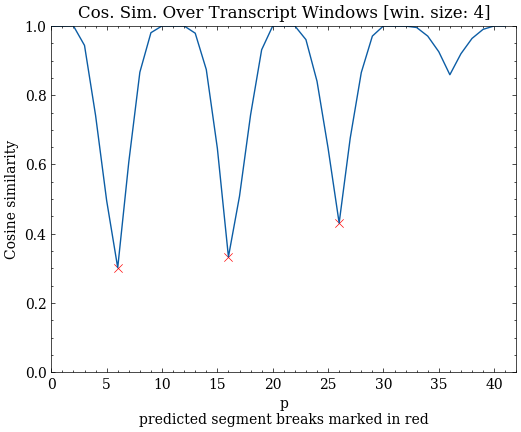

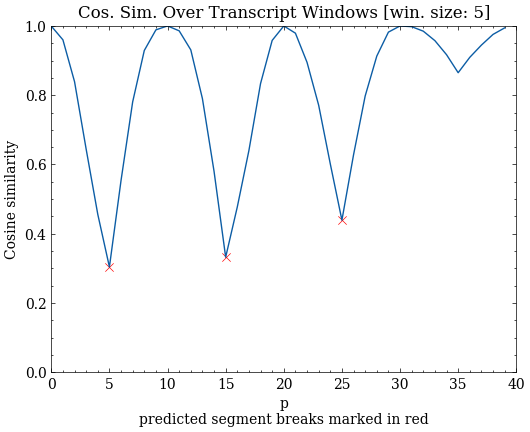

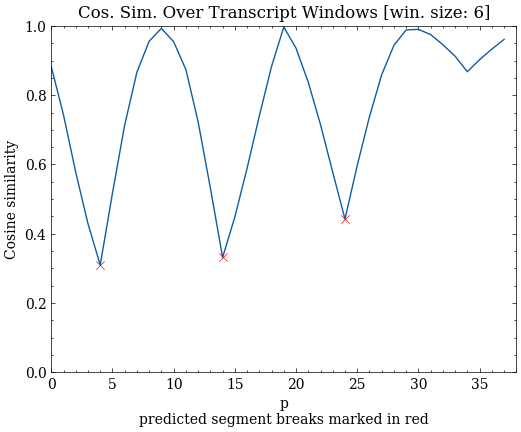

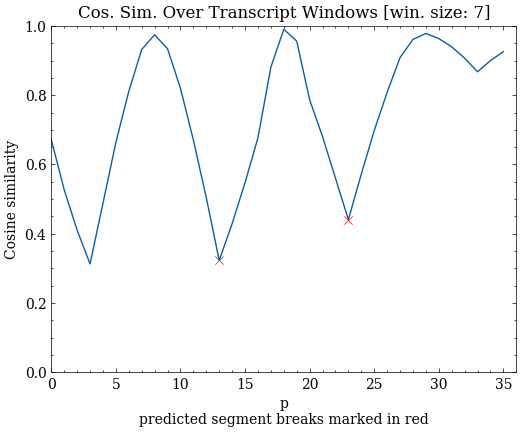

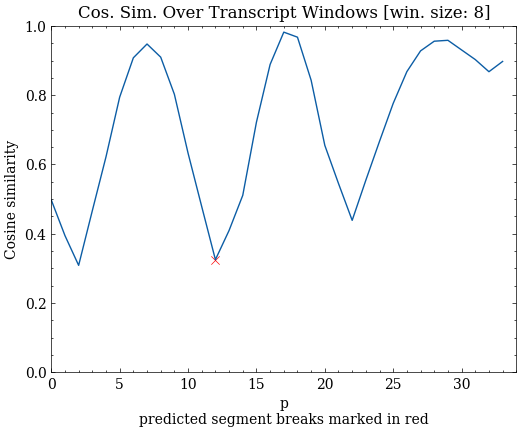

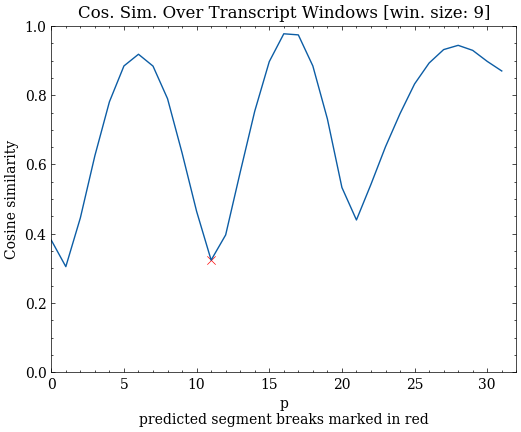

In [10]:
# Evaluate differente window sizes on synthetic data

windows_ls = [i for i in range(4, 10, 1)]

for window in windows_ls:
    bounds_testing = segmentation_main_call(testing_df, print_state_min=False, print_state_depth=False, window=window, height=0.95)
    con_sim = window_cosine_sim(testing_df, window_size = window)
    plot_cosine_scores(con_sim, window_size=window, boundaries=bounds_testing)
    print()